In [75]:
from pathlib import Path
import os

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import torch.optim as optim
 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix

In [76]:
# GPUを使える場合はGPUを使うための準備
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cpu


In [77]:
#前処理

In [78]:
transform_dict = {
        'train': transforms.Compose(
            [transforms.Resize((120,120)),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ]),
        'test': transforms.Compose(
            [transforms.Resize((32,32)),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ])}

In [79]:
data_folder = '/Users/nagasawanaokazu/Desktop/スクレイピング画像'

data = torchvision.datasets.ImageFolder(root=data_folder, transform=transform_dict['train'])

In [80]:
#trainとtestの分離

In [81]:
train_size = int(0.85 * len(data))
test_size = len(data) - train_size
train, test = torch.utils.data.random_split(data, [train_size, test_size])

In [82]:
#データローダ

In [83]:
train_loader = torch.utils.data.DataLoader(train, batch_size=5, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test,   batch_size=5, shuffle=False)
dataloaders  = {"train":train_loader, "test":test_loader}

In [84]:
#画像の確認

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


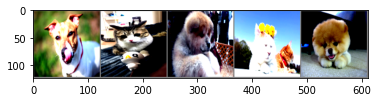

tensor(0) tensor(1) tensor(0) tensor(1) tensor(0)


In [85]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 訓練データをランダムに取得
dataiter = iter(dataloaders["train"])
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % labels[labels[j]] for j in range(5)))

In [86]:
#resnetを使用

In [87]:
model_ft = models.resnet18(pretrained=True)

In [88]:
#パラメーターを学習させないように、require_grad = Falseとする

In [89]:
for param in model_ft.parameters():
    param.require_grad = False

In [90]:
model_ft.fc = nn.Linear(in_features=512, out_features=2, bias=True)

In [91]:
model_ft = model_ft.to(device)

In [92]:
# 損失関数の定義
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


In [93]:
# 最適化関数の定義
optimizer = optim.SGD(model_ft.parameters(), lr=0.001)

In [94]:
param = {
    'trainloader': train_loader,
    'valloader': test_loader,
    'net': model_ft,
    'optimizer': optimizer,
    'lossfunc': loss_func,
    'epochs': 10,
    'device': device
    }

In [95]:
# 5エポック終了するまで時間がかかるので、注意してください。

def training(trainloader, valloader, net, optimizer, lossfunc, epochs, device):
    train_loss_track = []
    test_loss_track = []

    for epoch in range(1, epochs+1):
        running_loss = 0
        running_train_loss = 0
        running_test_loss = 0

        # 学習モード
        net.train()
        for step, batch  in enumerate(trainloader, 1):
            # device = "cuda"の場合、GPUにデータを転送する
            xx, yy = batch[0].to(device), batch[1].to(device)
            # 最後に計算した各パラメーターの勾配を初期化する
            optimizer.zero_grad()
            # フォワード計算を行う
            y_pred = net(xx)
            # 誤差関数を使ってギャップの計測
            loss = lossfunc(y_pred, yy)
            # 誤差逆伝播法を使って自動微分
            loss.backward()
            # パラメーターを更新
            optimizer.step()
            # 学習データを使って損失を計算
            running_loss += loss.item()
            running_train_loss += loss.item()

            # 100 iterationごとにlossを出力
            if step % 100 == 0:
                print('[{:d} epoch, {:5d} iter] train/loss: {}'.format(epoch, step, running_loss / 100))
                running_loss = 0.0
        # エポックが終了したら平均損失を計算
        train_loss_track.append(running_train_loss / len(train_loader))

        # 評価（evaluation）モード
        net.eval()
        # 勾配計算用のパラメータを保存しない
        with torch.no_grad():
            for step, batch in enumerate(valloader, 1):
                # device = "cuda"の場合、GPUにデータを転送する
                xx_test, yy_test = batch[0].to(device), batch[1].to(device)
                # 予測値を計算
                y_pred = net(xx_test)
                # 誤差関数を使ってギャップの計測
                test_loss = lossfunc(y_pred, yy_test)
                # テストデータを使って損失を計算
                running_test_loss += test_loss.item()
        # 誤差をトラッキング
        test_loss_track.append(running_test_loss / len(valloader))
        print('val/loss: {}'.format(running_test_loss / len(valloader)))
    return net, train_loss_track, test_loss_track

In [96]:
model_ft, train_loss_track, test_loss_track = training(**param)

val/loss: 0.5851088563601176
val/loss: 0.48862455288569134
val/loss: 0.3918224275112152
val/loss: 0.3169893076022466
val/loss: 0.29302117228507996
val/loss: 0.22405351450045904
val/loss: 0.21472153812646866
val/loss: 0.22099536408980688
val/loss: 0.22029950469732285
val/loss: 0.21816226343313852


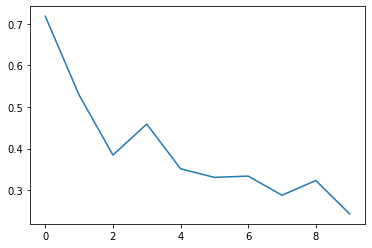

In [97]:
plt.plot(train_loss_track)

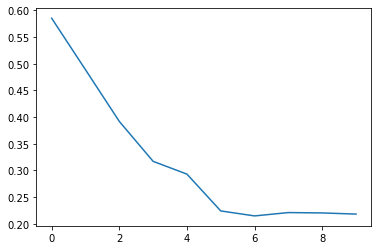

In [98]:
plt.plot(test_loss_track)

In [99]:
def calculate_accuracy(testloader, net):
    true = 0
    total = 0

    all_labels = np.array([])
    all_preds = np.array([])

    net.eval()
    with torch.no_grad():
        for test_xx, test_yy in testloader:
            
            # device = "cuda"の場合、GPUにデータを転送する
            test_xx = test_xx.to(device)
            test_yy = test_yy.to(device)

            outputs = net(test_xx)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels = np.append(all_labels, test_yy.cpu().data.numpy())
            all_preds = np.append(all_preds, predicted.cpu().numpy())
            
            total += test_yy.size(0)
            true += (predicted == test_yy).sum().item()
    print('Accuracy: {:.2f} %'.format(100 * float(true/total)))

    return all_labels, all_preds

In [100]:
all_labels, all_preds = calculate_accuracy(val_loader, model_ft)

Accuracy: 100.00 %


In [101]:
def plot_conf_mat(all_labels, all_preds):
    labels = np.unique(all_labels)
    cm = confusion_matrix(all_labels, all_preds, labels=labels)
    cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
    return cm_labeled

plot_conf_mat(all_labels, all_preds)

,0.0,1.0
0.0,5,0
1.0,0,8


In [49]:
net = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32, out_channels=36, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    Flatten(),
    nn.Linear(1764, 1000),
    nn.ReLU(),
    nn.Linear(1000, 100),
    nn.ReLU(),
    nn.Linear(100, 2),
)

In [45]:
class Flatten(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)

In [47]:
sample_data = torch.rand([2, 3, 32, 32])
sample_data.shape
# [データ数, チャンネル数, ピクセル数, ピクセル数]
# チャンネル数: 1チャンネルならば白黒、3チャンネルならばRGB

torch.Size([2, 3, 32, 32])

In [48]:
print(net(sample_data).shape)

torch.Size([2, 1764])


In [53]:
param = {
    'trainloader': train_loader,
    'valloader': val_loader,
    'net': net,
    'optimizer': optimizer,
    'lossfunc': loss_func,
    'epochs': 10,
    'device': device
    }

In [81]:
from icrawler.builtin import GoogleImageCrawler

In [84]:
crawler = GoogleImageCrawler(storage={"root_dir": "images"})
crawler.crawl(keyword="犬", max_num=10)

2020-12-30 00:54:45,338 - INFO - icrawler.crawler - start crawling...
2020-12-30 00:54:45,340 - INFO - icrawler.crawler - starting 1 feeder threads...
2020-12-30 00:54:45,342 - INFO - feeder - thread feeder-001 exit
2020-12-30 00:54:45,342 - INFO - icrawler.crawler - starting 1 parser threads...
2020-12-30 00:54:45,345 - INFO - icrawler.crawler - starting 1 downloader threads...
2020-12-30 00:54:46,207 - INFO - parser - parsing result page https://www.google.com/search?q=%E7%8A%AC&ijn=0&start=0&tbs=&tbm=isch
Exception in thread parser-001:
Traceback (most recent call last):
  File "/Users/nagasawanaokazu/opt/anaconda3/envs/tnsorflow_cpu/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/nagasawanaokazu/opt/anaconda3/envs/tnsorflow_cpu/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nagasawanaokazu/opt/anaconda3/envs/tnsorflow_cpu/lib/python3.6/site-packages/icrawler/parser.py", line 104, in